In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from ipywidgets import IntProgress
import IPython.display as display
import os
import imgaug.augmenters as iaa
import functools
tf.executing_eagerly()



True

In [2]:
data_dir = "resulting_data"
values = []
for currency in os.listdir(data_dir):
    for value in os.listdir(os.path.join(data_dir, currency)):
        values.append(os.path.join(currency, value))
print(values)
values_to_ints = {values[i]:i for i in range(len(values))}
len(values)

['Euro/50', 'Euro/10', 'Euro/100', 'Euro/5', 'Euro/200', 'Euro/20', 'Euro/500', 'USA/1', 'USA/2', 'USA/50', 'USA/10', 'USA/100', 'USA/5', 'USA/20', 'Kazah/1000', 'Kazah/10000', 'Kazah/2000', 'Kazah/200', 'Kazah/5000', 'Kazah/500', 'rubles/1000', 'rubles/2000', 'rubles/100', 'rubles/200', 'rubles/5000', 'rubles/500', 'China/1', 'China/50', 'China/10', 'China/100', 'China/5', 'China/20']


32

In [3]:
def get_train_and_test(list_ds):
    new_list = []
    for str in list_ds:
        new_list.append(str.numpy().decode("utf-8"))
    new_list = np.array(new_list)
    return new_list[int(new_list.shape[0] / 5):], new_list[:int(new_list.shape[0] / 5)]

In [4]:
def gen_labels(data):
    for string in data:
        split = string.split("/")
        yield values_to_ints[os.path.join(split[-3], split[-2])]
def gen_data(data):
    for string in data:
        img = Image.open(string)
        img = img.resize((256,128),resample=Image.BOX)
        img = np.array(img)
        img = iaa.Grayscale(alpha=1.0).augment_images([img])[0]
        img = img.astype(np.float32)
        img /= 255
        yield img
def gen_all(strings):
    data = gen_data(strings)
    labels = gen_labels(strings)
    for _ in range(len(strings)):
        yield (data.__next__(), labels.__next__())


In [5]:

list_ds = tf.data.Dataset.list_files(str(data_dir+'/*/*/*'))
train_strings, test_strings = get_train_and_test(list_ds) 


In [6]:
train_dataset = tf.data.Dataset.from_generator(functools.partial(gen_all, train_strings),
                                              output_types=(tf.float32, tf.int8),
                                               output_shapes=((128, 256, 3), ())
                                             )

test_dataset = tf.data.Dataset.from_generator(functools.partial(gen_all, test_strings),
                                              output_types=(tf.float32, tf.int8),
                                              output_shapes=((128, 256, 3), ())
                                             )
train_dataset = train_dataset.batch(32,drop_remainder=True)
test_dataset = test_dataset.batch(32,drop_remainder=True)


model1 = normal <br>
model2 = normal with more conv matrixes <br>
model3 = model2 with batchnormalization <br>
model4 = normal with only 2 conv layers <br>

In [7]:
def create_many_models():
    model1 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(4, 5, activation='relu', input_shape=(128, 256, 3)),
        tf.keras.layers.Conv2D(16, 5, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(16, 5, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(16, 5, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(len(values_to_ints), activation='softmax'),
    ])
    model2 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 5, activation='relu', input_shape=(128, 256, 3)),
        tf.keras.layers.Conv2D(64, 5, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, 5, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(16, 5, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(len(values_to_ints), activation='softmax'),
    ])
    model3 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 5, activation='relu', input_shape=(128, 256, 3)),
        tf.keras.layers.Conv2D(64, 5, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, 5, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(16, 5, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(len(values_to_ints), activation='softmax'),
    ])
    model4 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(4, 5, activation='relu', input_shape=(128, 256, 3)),
        tf.keras.layers.Conv2D(16, 5, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(len(values_to_ints), activation='softmax'),
    ])
    
    def callback_create(checkpoint_path):
        return tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=0,
                                                 save_best_only=True)

    def tensorboard_create(checkpoint_path):
        return tf.keras.callbacks.TensorBoard(log_dir=checkpoint_path, 
                                              histogram_freq=0,  
                                              write_graph=True)
    list_models = [model1, model2, model3, model4]
    return [(
        list_models[i], 
        callback_create(os.path.join("training",str(i))),
        tensorboard_create(os.path.join("tensorboard",str(i))),
    ) for i in range(len(list_models))]

In [8]:
model_list = create_many_models()
with tf.device('/GPU:0'):
    for model, cp_callback, tb_callback in model_list:
        model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'],
                     )
        model.fit(train_dataset, 
                  epochs=20, 
                  validation_data=test_dataset, 
                  validation_steps=9, 
                  callbacks=[cp_callback, tb_callback]
                 )

Epoch 1/20
    833/Unknown - 126s 151ms/step - loss: 1.2559 - accuracy: 0.6469WARNING:tensorflow:From /home/framaz/.conda/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1785: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: training/0/assets
833/833 [==============================] - 128s 154ms/step - loss: 1.2559 - accuracy: 0.6469 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
833/833 [==============================] - 118s 142ms/step - loss: 0.1258 - accuracy: 0.9613 - val_loss: 0.1442 - val_accuracy: 0.9549
Epoch 3/20
833/833 [==============================] - 117s 140ms/step - loss: 0.0691 - accuracy: 0.9785 - val_loss: 0.1705 - val_accuracy: 0.9514
Epoch 4/20
833/833 [===========================

833/833 [==============================] - 208s 249ms/step - loss: 3.4608 - accuracy: 0.0484 - val_loss: 3.4549 - val_accuracy: 0.0590
Epoch 17/20
833/833 [==============================] - 205s 246ms/step - loss: 3.4608 - accuracy: 0.0484 - val_loss: 3.4549 - val_accuracy: 0.0590
Epoch 18/20
833/833 [==============================] - 205s 247ms/step - loss: 3.4608 - accuracy: 0.0484 - val_loss: 3.4550 - val_accuracy: 0.0590
Epoch 19/20
833/833 [==============================] - 206s 247ms/step - loss: 3.4608 - accuracy: 0.0484 - val_loss: 3.4549 - val_accuracy: 0.0590
Epoch 20/20
833/833 [==============================] - 210s 252ms/step - loss: 3.4608 - accuracy: 0.0484 - val_loss: 3.4549 - val_accuracy: 0.0590
Epoch 1/20
    833/Unknown - 223s 267ms/step - loss: 0.6444 - accuracy: 0.8164INFO:tensorflow:Assets written to: training/2/assets
833/833 [==============================] - 227s 272ms/step - loss: 0.6444 - accuracy: 0.8164 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epo

Epoch 20/20
833/833 [==============================] - 115s 138ms/step - loss: 0.0570 - accuracy: 0.9826 - val_loss: 1.3864 - val_accuracy: 0.7708


In [9]:
test_data = [
    Image.open('100_1.jpg'),
    Image.open('100_2.jpg'),
    Image.open('100_3.jpg'),
    Image.open('1000_1.jpg'),
    Image.open('1000_2.jpg'),
    Image.open('1000_3.jpg'),
    Image.open('200_1.jpg'),
 #   Image.open('200_2.jpg'),
 #   Image.open('2000_1.jpg'),
    Image.open('5d_1.jpg'),
    Image.open('100d_1.jpg'),
    Image.open('100y_1.jpg'),
    Image.open('100y_2.jpg'),
]
for i in range(len(test_data)):
    img = test_data[i]
    img = img.resize((256,128),resample=Image.BOX)
    img = np.array(img)
    test_data[i]=img
    
test_data = np.array(test_data)

In [10]:
test_data = iaa.Grayscale(alpha=1.0).augment_images(test_data)
test_data = test_data.astype(np.float32)
test_data /= 255

In [11]:
result = []
for i in range(4):
    print(i)
    result.append(model_list[i][0].predict(test_data))

0
1
2
3


USA/5 0.45057031512260437
rubles/500 0.04879353940486908
rubles/100 1.0
rubles/100 0.9932029247283936


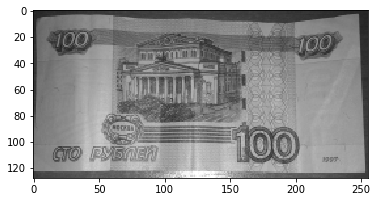

rubles/100 0.9984887838363647
rubles/500 0.04879353940486908
rubles/100 1.0
rubles/100 0.5267678499221802


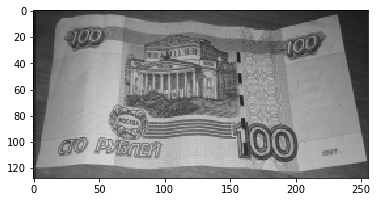

rubles/200 0.998244047164917
rubles/500 0.04879353940486908
rubles/100 0.9999998807907104
rubles/500 0.9832510352134705


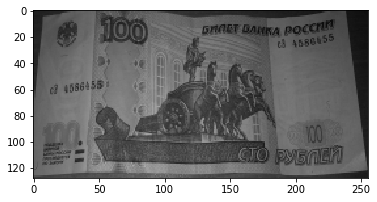

rubles/1000 0.7643352746963501
rubles/500 0.04879353940486908
rubles/1000 0.999998927116394
rubles/2000 0.8546916842460632


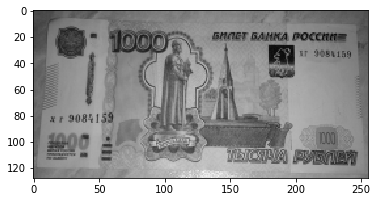

rubles/200 0.9931074976921082
rubles/500 0.04879353940486908
China/5 1.0
rubles/1000 0.9998562335968018


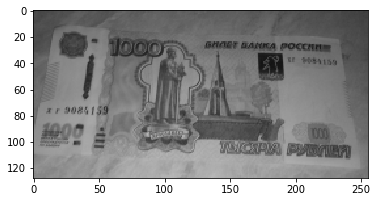

rubles/1000 0.9999704360961914
rubles/500 0.04879353940486908
China/20 0.8496332168579102
rubles/500 0.9694592952728271


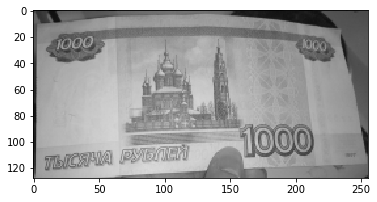

rubles/200 0.9820389151573181
rubles/500 0.04879353940486908
rubles/200 1.0
Euro/5 0.8510778546333313


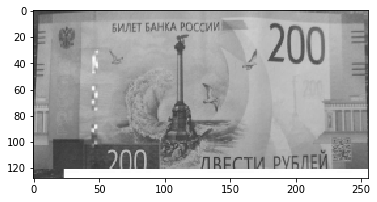

USA/5 0.9989089965820312
rubles/500 0.04879353940486908
USA/5 0.9999562501907349
USA/50 0.9050254821777344


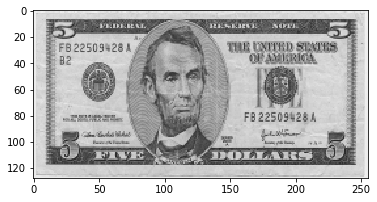

USA/100 1.0
rubles/500 0.04879353940486908
USA/100 1.0
USA/100 1.0


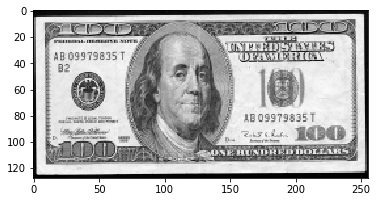

China/100 0.9946740865707397
rubles/500 0.04879353940486908
China/100 0.9999885559082031
China/50 0.9995531439781189


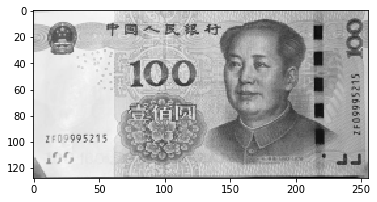

China/100 0.9436811208724976
rubles/500 0.04879353940486908
China/100 0.9999642372131348
China/100 0.9999887943267822


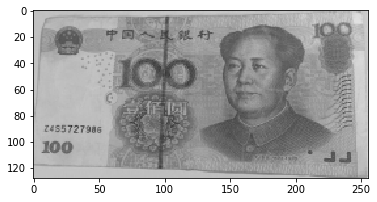

In [15]:
for i in range(11):
    print(f"{values[np.argmax(result[0][i])]} {result[0][i][np.argmax(result[0][i])]}")
    print(f"{values[np.argmax(result[1][i])]} {result[1][i][np.argmax(result[1][i])]}")
    print(f"{values[np.argmax(result[2][i])]} {result[2][i][np.argmax(result[2][i])]}")
    print(f"{values[np.argmax(result[3][i])]} {result[3][i][np.argmax(result[3][i])]}")
    
    plt.imshow(test_data[i])
    plt.show()

In [16]:
for i in range(4):
    model_list[i][0].save(os.path.join('backup',str(i)))

INFO:tensorflow:Assets written to: backup/0/assets
INFO:tensorflow:Assets written to: backup/1/assets
INFO:tensorflow:Assets written to: backup/2/assets
INFO:tensorflow:Assets written to: backup/3/assets
